Author: Cezary Januszek

*Created on Saturday, November 11th 2023*
# [Swisscom challenge] Flight delays prediction

#### Research question: *What is the influence of the different airlines/airports on the flight delays?*

The goal of this challenge is to investigate US flight delays and cancellations data from 2015.

First some exploratory data analysis is done to try to find some insights from general statistics about the airlines, airports and average flight delays. Second, using this same data the goal consists in creating a flight delay prediction model by implementing a:
1) baseline model 
2) complex model (Neural Network or other Deep Learning method)

The second model should have better performance than the baseline due to its increased complexity, which will make it also more difficult to explain its predictions.Therefore, an interpretability framework will be added to the second model to allow explicability of the created predictions.

# III. Baseline predicton model

In this notebook, we build the baseline flight delay prediction model. As mentioned in the previous steps, our delays are defined only by the arrival delays of the flights. Moreover, the arrival delays are probably correlated with the departure delays as the already provide important information about the potential final delay of the flight. Therefore, we will check the correlation between these two delay measures and decide to drop the departure delay feature based on the outcome, to ensure that we do not provide to our model to much information about the predicted value (arrival delay).

To solve our flight prediction problem, a **classification model** will allow passengers to predict if their flight would be delayed or not.

The pipeline to build our baseline regression model is as follows:
1. Data pre-processing for feature cleaning and extraction
2. Train-test split
3. Choosing the model and hyperparameters tuning
4.



-----------------------------
Glossary of *flights_df* feature columns:
   - *AIRLINE*: IATA CODE for the airline
   - *ORIGIN_AIRPORT and DESTINATION_AIRPORT*: origin and destination airport of the flight
   - *SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL*: scheduled times and date of flight departure and landing
   - *DEPARTURE_TIME and ARRIVAL_TIME*: actual real times of flight takeoff and landing
   - *DATE_OF_WEEK*: day of week of scheduled flight
   - *DEPARTURE_DELAY and ARRIVAL_DELAY*: differences between scheduled and real times of flight departure and arrival
   - *DISTANCE*: travel distance between origin and destination airports (in miles)
   - *SCHEDULED_TIME*: scheduled travel time between origin and destination airports
   - *TAIL_NUMBER*: code to identify a specific plane

In [60]:
# Imports
%load_ext autoreload
%autoreload 2

from IPython.core.pylabtools import figsize
figsize(10, 8)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import datetime
import plotly.express as px
import math
from helper_functions import *

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# Load data
flights_df = pd.read_pickle(os.path.abspath('./Data/flights.pkl'))
airports_df = pd.read_pickle(os.path.abspath('./Data/airports.pkl'))
airlines_df = pd.read_csv(os.path.abspath('./Data/airlines.csv'))
                          

In [62]:
# create label encoding and decoding dictionaries for airports
airports_decoding = flights_df.groupby('ORIGIN_AIRPORT')['ARRIVAL_DELAY'].count().sort_values().reset_index()['ORIGIN_AIRPORT'].to_dict()
airports_encoding = {v: k for k, v in airports_decoding.items()}

### Data pre-processing for classification

For the task of classification we need to extract some information from dates and hours to put them in simple numerical values as well as we should encode categorical factors (airline, airport).

In [63]:
# extract day, month from dates and hour, minutes from time
flights_df['DEPARTURE_DAY'] = flights_df['DATE'].apply(lambda x: x.day)
flights_df['DEPARTURE_MONTH'] = flights_df['DATE'].apply(lambda x: x.month)

flights_df['ARRIVAL_DAY'] = flights_df['ARRIVAL_DATE'].apply(lambda x: x.day)
flights_df['ARRIVAL_MONTH'] = flights_df['ARRIVAL_DATE'].apply(lambda x: x.month)

flights_df['SCHEDULED_DEPARTURE_HOUR'] = flights_df['SCHEDULED_DEPARTURE'].apply(lambda x: x.hour)
flights_df['SCHEDULED_DEPARTURE_MIN'] = flights_df['SCHEDULED_DEPARTURE'].apply(lambda x: x.minute)

flights_df['SCHEDULED_ARRIVAL_HOUR'] = flights_df['SCHEDULED_ARRIVAL'].apply(lambda x: x.hour)
flights_df['SCHEDULED_ARRIVAL_MIN'] = flights_df['SCHEDULED_ARRIVAL'].apply(lambda x: x.minute)

flights_df = flights_df.drop(['DATE', 'ARRIVAL_DATE', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL'], axis=1)

# we also drop DEPARTURE_TIME and DEPARTURE_DELAY as both these features are strongly correlated with our target variable - arrival delay
# ARRIVAL_TIME is dropped as well as it indicates almost directly our arrival delay
flights_df = flights_df.drop(['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_TIME'], axis=1)

# TAIL_NUMBER is generally not known to passengers before departure so we drop this column as well
flights_df = flights_df.drop('TAIL_NUMBER', axis=1)

In [64]:
# encode airlines and airports
#flights_df['AIRLINE'] = flights_df['AIRLINE'].map(airlines_encoding)
flights_df['ORIGIN_AIRPORT'] = flights_df['ORIGIN_AIRPORT'].map(airports_encoding)
flights_df['DESTINATION_AIRPORT'] = flights_df['DESTINATION_AIRPORT'].map(airports_encoding)

In [65]:
# clean delay outliers as seen from boxplots in the EDA part - we get rid of all flights that have a delay exceeding 3h
#flights_df = flights_df[flights_df['ARRIVAL_DELAY'] < 180]

In [66]:
flights_df['FLIGHT_DELAY'] = (flights_df['ARRIVAL_DELAY'] > 0).apply(int)
flights_df = flights_df.drop('ARRIVAL_DELAY', axis=1)

### Classification model - baseline

In [67]:
# separate data into feature matrix X and target variable vector Y
X = pd.get_dummies(flights_df.drop('FLIGHT_DELAY', axis=1))
Y = flights_df['FLIGHT_DELAY'] 

In [68]:
# train-test split with test size of 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
print('Train samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])

# standardizing training data
#scaler = StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)


Train samples:  3999805
Test samples:  1714203


In [70]:
# define the model

clf_model = DecisionTreeClassifier(class_weight='balanced')
clf_model.fit(X_train, Y_train)

scores = cross_val_score(clf_model, X_train, Y_train, cv=5)
print('R-squared = {:.3f}'.format(scores.mean()))

y_pred_proba = clf_model.predict_proba(X_test)
loss = log_loss(Y_test, y_pred_proba)
y_pred = clf_model.predict(X_test)
acc = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print('Cross-entropy loss = {:.3f}'.format(loss))
print('Accuracy = {:.3f}'.format(acc))
print('Precision = {:.3f}'.format(precision))
print('Recall = {:.3f}'.format(recall))
print('F1-score = {:.3f}'.format(f1))

R-squared = 0.618
Cross-entropy loss = 13.612
Accuracy = 0.622
Precision = 0.483
Recall = 0.480
F1-score = 0.482


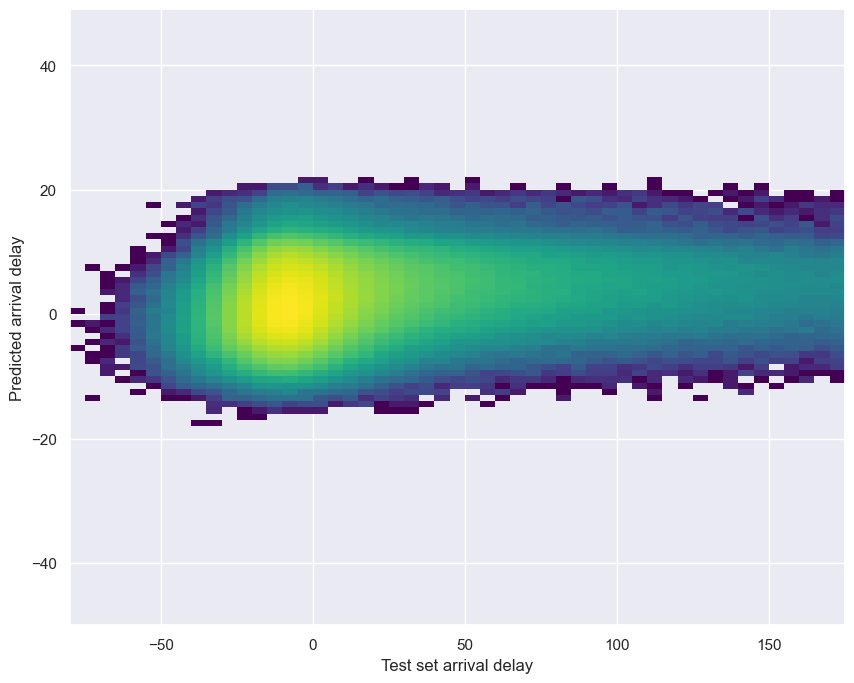

In [187]:
plt.figure()
plt.hist2d(x=Y_test, y=y_pred, bins=(np.arange(-80, 180, 5), np.arange(-50, 50, 1)), cmin=1, cmap='viridis', norm='log')
plt.xlabel('Test set arrival delay')
plt.ylabel('Predicted arrival delay')
plt.show()